## 0. Setup

In [1]:
import pickle
from itertools import combinations
import pprint
import json
import glob
from random import random, randrange
from datetime import datetime, timedelta
import itertools
from collections import defaultdict
import networkx as nx
import numpy
import time
import scipy
import mpmath
import numpy as np
import pandas as pd
import random
import powerlaw
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.pylab import plot

from tqdm import trange, tqdm

%matplotlib inline

In [2]:
start_time = time.time()

In [3]:
# Load the data
f = open('pruned_retweet_dict','rb')
retweet_dict = pickle.load(f)
f.close()

In [4]:
len(retweet_dict)

1271425

## 1. Decay Analysis and Distribution

In [5]:
# Given a tweet, find the latest retweet for it
# substract time latest retweet to time of tweet, to get a time_span
# and return [tweet_id,time_span]
def tweet_span(t):
    authored_date = datetime.strptime(retweet_dict[t]['date'],'%y-%m-%d-%H:%M:%S')
    retweet_list = retweet_dict[t]['rt_list']
    retweet_list.sort(key=lambda x: datetime.strptime(x[1], '%y-%m-%d-%H:%M:%S'), reverse=True)
    latest_retweet_date = datetime.strptime(retweet_list[0][1],'%y-%m-%d-%H:%M:%S')
    time_span = latest_retweet_date - authored_date
    # Now in hours
    s1 = time_span.seconds
    s2 = time_span.days*24*60*60
    time = s1 + s2
    return([t,time])

In [6]:
recompute = False

In [7]:
# Now we store data for all tweets
if recompute:
    elapsed_time = time.time() - start_time
    print(elapsed_time)

    full_data = []
    time_data = []

    for t in tqdm(retweet_dict):
        data = tweet_span(t)
        full_data.append(data)

    full_data = np.array(full_data)
    df = pd.DataFrame(data=full_data, columns=["Tweet_id", "sec_span"])
    f = open("tweet_secspan.pkl","wb")
    pickle.dump(df,f)
    
    elapsed_time2 = time.time() - start_time
    elapsed_time2 = elapsed_time2 - elapsed_time
    print(elapsed_time2)

  0%|          | 876/1271425 [00:00<02:26, 8694.17it/s]

16.24827742576599


100%|██████████| 1271425/1271425 [02:50<00:00, 7460.78it/s] 


170.9027750492096


In [8]:
# We need some basic pruning to even visualize it intelligibly
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def seconds_to_hs(data):
    return data/3600

with open('tweet_secspan.pkl', 'rb') as f:
    data = pickle.load(f)
    
time_span = data[['sec_span']]

pruned_time_data = reject_outliers(time_span).dropna()
pruned_time_data = seconds_to_hs(pruned_time_data)
pruned_time_data = pruned_time_data.to_numpy()
# displace it a bit for visualization and power law fit later
pruned_time_data = pruned_time_data + 0.1

In [9]:
# Now lets look for the % intervals in hours

def find_hs_break(percent):
    hs = 1
    while True:
        subset = pruned_time_data[pruned_time_data<hs]
        actual_percent = len(subset)*100/len(pruned_time_data)
        if actual_percent < percent:
            hs += 1
        else:      
            break
    return([actual_percent,hs])

data = []
for percent in [*range(90,100,1)]:
    data.append(find_hs_break(percent))
    
print(data)

# So 90% decay in 56hs, 94% decay in 120hs (5 days) and so on

[[90.13664680291893, 44], [91.09859327305769, 49], [92.05820472623536, 56], [93.05292195165549, 66], [94.073163327995, 77], [95.00596234503338, 93], [96.02958547007515, 113], [97.01488210982471, 139], [98.0285210244122, 171], [99.01091902241697, 219]]


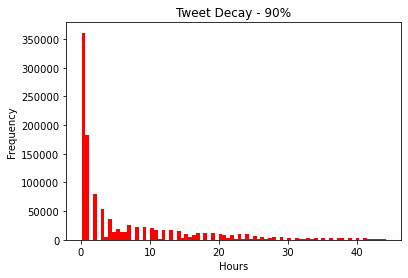

In [10]:
# Now lets plot the decay within 44hs (90%)
num_bins = 80
data = pruned_time_data[pruned_time_data<45]

plt.hist(data, num_bins, color='red')
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.title("Tweet Decay - 90%")
plt.show()


In [11]:
# Indeed we can do some kind of power law analysis
# https://pypi.org/project/powerlaw/
# https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0085777&type=printable

results = powerlaw.Fit(pruned_time_data[pruned_time_data<45])
print("alpha is: " + str(results.power_law.alpha))
print("xmin is: " + str(results.power_law.xmin))
R, p = results.distribution_compare('power_law', 'lognormal')
print("p is: " + str(p))

Calculating best minimal value for power law fit
C:\Users\u1085188\AppData\Local\Continuum\anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha is: 4.417544467703715
xmin is: 21.03388888888889
p is: 0.0


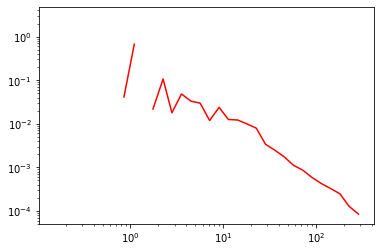

In [12]:
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777


powerlaw.plot_pdf(pruned_time_data,color='r')


In [13]:
?powerlaw.plot_pdf

## 2. Retweet Analysis and Distribution

I.e. How often are tweets retweeted?

Does it follow some kind of power law distribution?

In [14]:
# Lets first take a look at a simple count
def disregard_tweets(n):
    tweets = []
    for t in tqdm(retweet_dict):    
        if len(retweet_dict[t]['rt_list'])>n-1:
            tweets.append(t)
    return(tweets)

for i in range(5):
    print("Tweets retweeted a.l. " + str(i) + "-times: " + str(len(disregard_tweets(i))))

  1%|          | 8059/1271425 [00:00<00:15, 80469.21it/s]

Tweets retweeted a.l. 0-times: 1271425


 13%|█▎        | 166484/1271425 [00:00<00:00, 1652787.43it/s]

Tweets retweeted a.l. 1-times: 1271425


 13%|█▎        | 171358/1271425 [00:00<00:00, 1700788.11it/s]

Tweets retweeted a.l. 2-times: 642520


 13%|█▎        | 161524/1271425 [00:00<00:00, 1606462.93it/s]

Tweets retweeted a.l. 3-times: 440088


100%|██████████| 1271425/1271425 [00:00<00:00, 1456206.03it/s]

Tweets retweeted a.l. 4-times: 338593


In [15]:
# Given a tweet, find the amount of retweets that it had 
# and return [tweet_id,retweet_count]
def retweet_count(t):
    count = len(retweet_dict[t]['rt_list'])
    return([t,count])

In [16]:
# Now we store data for all tweets
if recompute:
    elapsed_time = time.time() - start_time
    print(elapsed_time)

    full_retweet_data = []
    count_retweet_data = []

    for t in tqdm(retweet_dict):
        data = retweet_count(t)
        full_retweet_data.append(data)

    full_retweet_data = np.array(full_retweet_data)
    df = pd.DataFrame(data=full_retweet_data, columns=["Tweet_id", "tweet_retweets"])
    f = open("tweet_retweet.pkl","wb")
    pickle.dump(df,f)
    
    elapsed_time2 = time.time() - start_time
    elapsed_time2 = elapsed_time2 - elapsed_time
    print(elapsed_time2)

  0%|          | 0/1271425 [00:00<?, ?it/s]

278.5843937397003


100%|██████████| 1271425/1271425 [00:38<00:00, 33199.87it/s] 


38.875978231430054


In [17]:
# We need some basic pruning to even visualize it intelligibly
with open('tweet_retweet.pkl', 'rb') as f:
    data = pickle.load(f)
    
retweet_count = data[['tweet_retweets']]

pruned_retweet_count = reject_outliers(retweet_count).dropna()
pruned_retweet_count = pruned_retweet_count.to_numpy()


In [18]:
# Now lets look for the % intervals in retweets

def find_retweet_break(percent):
    retweets = 1
    while True:
        subset = pruned_retweet_count[pruned_retweet_count<retweets]
        actual_percent = len(subset)*100/len(pruned_retweet_count)
        if actual_percent < percent:
            retweets += 1
        else:      
            break
    return([actual_percent,retweets])

data = []
for percent in [*range(80,100,1)]:
    data.append(find_retweet_break(percent))
    
print(data)

# So 90% of tweets were retweeted <= 13 times, 
# 95% of tweets were retweeted <= 29 times, 

[[81.56163882530254, 6], [81.56163882530254, 6], [83.90151156851246, 7], [83.90151156851246, 7], [85.67328490260252, 8], [85.67328490260252, 8], [87.06251537108156, 9], [87.06251537108156, 9], [88.186417324076, 10], [89.10458326238988, 11], [90.54875549417633, 13], [91.1263928564672, 14], [92.07711395725735, 16], [93.16806661747921, 19], [94.21984272624655, 23], [95.13438266583427, 28], [96.02495948340554, 35], [97.02147852462842, 48], [98.00128644128719, 72], [99.0017467854733, 136]]


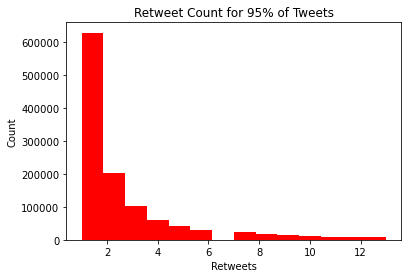

In [19]:
# Now lets plot the data within 13 retweets (90%)
plt.hist(pruned_retweet_count[pruned_retweet_count<14], 14, facecolor='red')
plt.xlabel('Retweets')
plt.ylabel('Count')
plt.title("Retweet Count for 95% of Tweets")
plt.show()

# Super power law like

In [20]:
# Indeed we can do some kind of power law analysis
# https://pypi.org/project/powerlaw/

results = powerlaw.Fit(pruned_retweet_count[pruned_retweet_count<14])
print("alpha is: " + str(results.power_law.alpha))
print("xmin is: " + str(results.power_law.xmin))
R, p = results.distribution_compare('power_law', 'lognormal')
print("p is: " + str(p))

Calculating best minimal value for power law fit
C:\Users\u1085188\AppData\Local\Continuum\anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha is: 2.8053755227945945
xmin is: 2.0
p is: 1.8037587797196535e-29


## 3. Author Retweet and Tweet Analysis

Do author's retweets also have a power law distribution?
Im doing it as exploratory because it does not involve much innovation

To each author we attribute the total amount of retweets they got

In [21]:
# Generate author set
rt_author_set = set()
for a in retweet_dict:
    rt_author_set.add(retweet_dict[a]['author'])

In [22]:
# Generate a dictionary with author data
author_data = dict()
for author in rt_author_set:
    author_data[str(author)] = np.zeros(8)

# [retweets, tweets,...]

# Retweet and Tweet counts
for t in tqdm(retweet_dict):  
    author=retweet_dict[t]['author']
    author_data[author][0] += retweet_dict[t]['rt_count']
    author_data[author][1] += 1

100%|██████████| 1271425/1271425 [00:03<00:00, 419075.51it/s]


In [23]:
retweets = []
tweets = []
for author in author_data:  
    retweets.append(author_data[author][0])
    tweets.append(author_data[author][1])
    
retweets = np.array(retweets)
tweets = np.array(tweets)

### For Retweets

In [24]:
# Now lets look for the % intervals in retweets
def find_retweet_break(percent):
    ret = 1
    while True:
        subset = retweets[retweets<ret]
        actual_percent = len(subset)*100/len(retweets)
        if actual_percent < percent:
            ret += 1
        else:      
            break
    return([actual_percent,ret])

rt_data = []
for percent in [*range(90,100,1)]:
    rt_data.append(find_retweet_break(percent))
    
print(rt_data)

# So 90% of authors were retweeted <= 19 times, 
# 95% of authors were retweeted <= 47 times, 

[[90.11876937931912, 19], [91.17641004721209, 22], [92.20411042726661, 26], [93.03233363959752, 30], [94.07930807994805, 37], [95.0624722818429, 47], [96.04432659614481, 63], [97.00260293377396, 90], [98.00597682995975, 150], [99.000555766593, 359]]


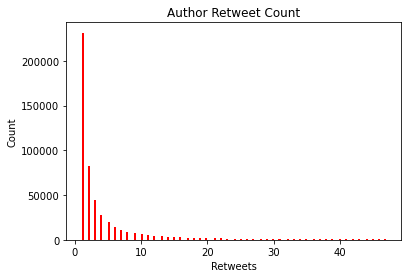

In [25]:
# Now lets plot the decay within 47 retweets (95%)
plt.hist(retweets[retweets<48], 150, facecolor='red')
plt.xlabel('Retweets')
plt.ylabel('Count')
plt.title("Author Retweet Count")
plt.show()

# Super power law like

In [26]:
# Indeed we can do some kind of power law analysis
# https://pypi.org/project/powerlaw/

results = powerlaw.Fit(retweets[retweets<48])
print("alpha is: " + str(results.power_law.alpha))
print("xmin is: " + str(results.power_law.xmin))
R, p = results.distribution_compare('power_law', 'lognormal')
print("p is: " + str(p))

Calculating best minimal value for power law fit


alpha is: 2.1885876135425097
xmin is: 3.0
p is: 1.9667641660108692e-199


### For Tweets

In [27]:
# Now lets look for the % intervals in tweets
def find_tweet_break(percent):
    tw = 1
    while True:
        subset = tweets[tweets<tw]
        actual_percent = len(subset)*100/len(tweets)
        if actual_percent < percent:
            tw += 1
        else:      
            break
    return([actual_percent,tw])

t_data = []
for percent in [*range(90,100,1)]:
    t_data.append(find_tweet_break(percent))
    
print(t_data)

# So 91% of authors tweeted <= 5 times, 
# 95% of authors tweeted <= 8 times, 

[[91.754631856092, 5], [91.754631856092, 5], [93.6210345492209, 6], [93.6210345492209, 6], [94.82912516350204, 7], [95.7101181331482, 8], [96.37273412837273, 9], [97.25054594243605, 11], [98.06623165923462, 14], [99.02113971448193, 22]]


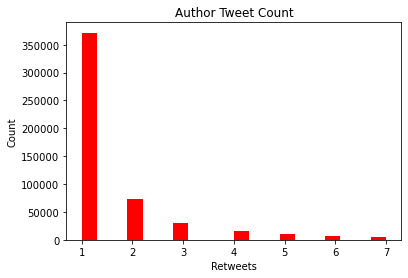

In [28]:
plt.hist(tweets[tweets<8], 20, facecolor='red')
plt.xlabel('Retweets')
plt.ylabel('Count')
plt.title("Author Tweet Count")
plt.show()

# Super power law like

In [29]:
# Indeed we can do some kind of power law analysis
# https://pypi.org/project/powerlaw/

results = powerlaw.Fit(retweets[retweets<48])
print("alpha is: " + str(results.power_law.alpha))
print("xmin is: " + str(results.power_law.xmin))
R, p = results.distribution_compare('power_law', 'lognormal')
print("p is: " + str(p))

Calculating best minimal value for power law fit


alpha is: 2.1885876135425097
xmin is: 3.0
p is: 1.9667641660108692e-199


In [30]:
elapsed_time = time.time() - start_time
print(elapsed_time)

381.76751375198364
